<h1>1.사전 준비</h1>

구글 드라이브에 연결한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


필요한 모듈(pyspark, pandas)를 준비한다.

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 198 kB 83.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=2a63ad30af3c4ef158cf31dd680ecdf9e2ef70a3f6d95ed342a899d44a9b276d
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pandas as pd

기존 csv파일이 euc-kr형식으로 encoding되었기 때문에 utf-8형식으로 변환하여 코로나 이전(2018년-2019년)과 이후(2020년-2021년) csv파일을 합쳤다.<br>
반복문을 이용하여 합쳤으며, 합칠때 이용한 코드는 아래와 같다.(로컬 IDE(a.k.a. 파이참)에서 했기때문에 아래 셀에서는 실행불가.)

In [ ]:
import pandas as pd
import glob
import os


input_file = r'D:\공부\2021 이어드림\project\csv\2.일별\2018_2019'
output_file = r'D:\공부\2021 이어드림\project\csv\2.일별\2018_2019\result.csv'

allFile_list = glob.glob(os.path.join(input_file, 'CARD_SUBWAY_MONTH_*'))
print(allFile_list)
allData = []
for file in allFile_list:
    df = pd.read_csv(file, encoding='utf-8')
    allData.append(df)

dataCombine = pd.concat(allData, axis=0, ignore_index=True)
dataCombine.to_csv(output_file, encoding='utf-8', index=False)


판다스로 합친 csv 파일을 구글 드라이브에 저장하고 pandas로 읽어옴. 아무래도 pandas가 보기에 더 좋다.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/previous_corona.csv', encoding='utf-8')

In [ ]:
data

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
0,20180101,1호선,서울역,40213.0,34505.0,20180104
1,20180101,우이신설선,신설동,699.0,809.0,20180104
2,20180101,우이신설선,보문,754.0,803.0,20180104
3,20180101,우이신설선,성신여대입구(돈암),2228.0,2276.0,20180104
4,20180101,우이신설선,정릉,1844.0,1685.0,20180104
...,...,...,...,...,...,...
428513,20191231,9호선,사평,3525.0,3391.0,20200103
428514,20191231,9호선,신논현,38032.0,38915.0,20200103
428515,20191231,공항철도 1호선,서울역,15568.0,13292.0,20200103
428516,20191231,공항철도 1호선,공덕,2488.0,3261.0,20200103


In [ ]:
data["노선명"].unique()

array(['1호선', '우이신설선', '9호선2단계', '공항철도 1호선', '9호선', '8호선', '7호선', '6호선',
       '5호선', '경강선', '수인선', '경춘선', '경의선', '장항선', '중앙선', '일산선', '분당선',
       '과천선', '안산선', '경원선', '경인선', '경부선', '4호선', '3호선', '2호선', '9호선2~3단계'],
      dtype=object)

<h1>2.전처리

전처리를 위해 spark dataframe을 준비했다.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.format("csv").option("header", True).load("/content/drive/MyDrive/data/previous_corona.csv", encoding='utf-8')

스키마 확인결과, '사용일자'와 '승차총승객수', '하차총승객수'의 데이터 타입을 변환해야한다. 또한 '등록일자'는 단순히 데이터를 등록한 날짜를 입력한 데이터 이므로 이 칼럼을 삭제한다.

In [ ]:
# 타입 확인
df.printSchema()

root
 |-- 사용일자: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: string (nullable = true)
 |-- 하차총승객수: string (nullable = true)
 |-- 등록일자: string (nullable = true)



In [ ]:
# 데이터 확인
df.show()

+--------+--------------+------------------+------------+------------+--------+
|사용일자|        노선명|              역명|승차총승객수|하차총승객수|등록일자|
+--------+--------------+------------------+------------+------------+--------+
|20180101|         1호선|            서울역|     40213.0|     34505.0|20180104|
|20180101|    우이신설선|            신설동|       699.0|       809.0|20180104|
|20180101|    우이신설선|              보문|       754.0|       803.0|20180104|
|20180101|    우이신설선|성신여대입구(돈암)|      2228.0|      2276.0|20180104|
|20180101|    우이신설선|              정릉|      1844.0|      1685.0|20180104|
|20180101|    우이신설선|      북한산보국문|      2706.0|      2637.0|20180104|
|20180101|    우이신설선|              솔샘|      2242.0|      2128.0|20180104|
|20180101|    우이신설선|        삼양사거리|      1141.0|      1170.0|20180104|
|20180101|    우이신설선|              삼양|      1079.0|      1206.0|20180104|
|20180101|    우이신설선|              화계|      1492.0|      1418.0|20180104|
|20180101|    우이신설선|            가오리|      1783.0|      1796.0|20180

필요없는 등록일자 컬럼 제거

In [ ]:
df = df.drop('등록일자')
df.show()

+--------+--------------+------------------+------------+------------+
|사용일자|        노선명|              역명|승차총승객수|하차총승객수|
+--------+--------------+------------------+------------+------------+
|20180101|         1호선|            서울역|     40213.0|     34505.0|
|20180101|    우이신설선|            신설동|       699.0|       809.0|
|20180101|    우이신설선|              보문|       754.0|       803.0|
|20180101|    우이신설선|성신여대입구(돈암)|      2228.0|      2276.0|
|20180101|    우이신설선|              정릉|      1844.0|      1685.0|
|20180101|    우이신설선|      북한산보국문|      2706.0|      2637.0|
|20180101|    우이신설선|              솔샘|      2242.0|      2128.0|
|20180101|    우이신설선|        삼양사거리|      1141.0|      1170.0|
|20180101|    우이신설선|              삼양|      1079.0|      1206.0|
|20180101|    우이신설선|              화계|      1492.0|      1418.0|
|20180101|    우이신설선|            가오리|      1783.0|      1796.0|
|20180101|    우이신설선|      4.19민주묘지|      1393.0|      1347.0|
|20180101|    우이신설선|          솔밭공원|      1150.0|      1

In [ ]:
import pyspark.sql.types as T
import pyspark.sql.functions as F

컬럼 DataType 변환

In [ ]:
df = df.withColumn('사용일자',F.to_date(F.col("사용일자"),"yyyyMMdd"))\
.withColumn('승차총승객수',F.col('승차총승객수').cast(T.IntegerType()))\
.withColumn('하차총승객수',F.col('하차총승객수').cast(T.IntegerType()))

스키마 확인 결과 제대로 변경이 됨

In [ ]:
df.printSchema()

root
 |-- 사용일자: date (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)



In [ ]:
df.show()

+----------+--------------+------------------+------------+------------+
|  사용일자|        노선명|              역명|승차총승객수|하차총승객수|
+----------+--------------+------------------+------------+------------+
|2018-01-01|         1호선|            서울역|       40213|       34505|
|2018-01-01|    우이신설선|            신설동|         699|         809|
|2018-01-01|    우이신설선|              보문|         754|         803|
|2018-01-01|    우이신설선|성신여대입구(돈암)|        2228|        2276|
|2018-01-01|    우이신설선|              정릉|        1844|        1685|
|2018-01-01|    우이신설선|      북한산보국문|        2706|        2637|
|2018-01-01|    우이신설선|              솔샘|        2242|        2128|
|2018-01-01|    우이신설선|        삼양사거리|        1141|        1170|
|2018-01-01|    우이신설선|              삼양|        1079|        1206|
|2018-01-01|    우이신설선|              화계|        1492|        1418|
|2018-01-01|    우이신설선|            가오리|        1783|        1796|
|2018-01-01|    우이신설선|      4.19민주묘지|        1393|        1347|
|2018-01-01|    우이신설선|   

Null값 확인 결과 없음(모든 칼럼)

In [ ]:
df.where(F.col('하차총승객수').isNull()==True).count()

0

이상치 확인결과 없음(승객수 칼럼)

In [ ]:
df.where(F.col('하차총승객수')<0).count()

0

'승차총승객수'와 '하차총승객수'를 더한 '이용자수' 칼럼 생성.

In [ ]:
df = df.withColumn('이용자수', sum([df[col] for col in ["`승차총승객수`","`하차총승객수`"]]))

In [ ]:
df.show()

+----------+--------------+------------------+------------+------------+--------+
|  사용일자|        노선명|              역명|승차총승객수|하차총승객수|이용자수|
+----------+--------------+------------------+------------+------------+--------+
|2018-01-01|         1호선|            서울역|       40213|       34505|   74718|
|2018-01-01|    우이신설선|            신설동|         699|         809|    1508|
|2018-01-01|    우이신설선|              보문|         754|         803|    1557|
|2018-01-01|    우이신설선|성신여대입구(돈암)|        2228|        2276|    4504|
|2018-01-01|    우이신설선|              정릉|        1844|        1685|    3529|
|2018-01-01|    우이신설선|      북한산보국문|        2706|        2637|    5343|
|2018-01-01|    우이신설선|              솔샘|        2242|        2128|    4370|
|2018-01-01|    우이신설선|        삼양사거리|        1141|        1170|    2311|
|2018-01-01|    우이신설선|              삼양|        1079|        1206|    2285|
|2018-01-01|    우이신설선|              화계|        1492|        1418|    2910|
|2018-01-01|    우이신설선|            가오리|   

중복되는 노선(9호선, 9호선2~3단계, 9호선2단계)를 하나의 노선으로 통합하고, '공항철도 1호선' 노선은 '공항철도' 노선으로 수정했다.

먼저 '9호선 2단계'와 '9호선 2~3단계' 를 '9호선'으로 바꿔주고

In [ ]:
df2 = df.withColumn("노선명", F.when(df.노선명 == "9호선2~3단계","9호선").otherwise(df.노선명))

In [ ]:
df3 = df2.withColumn("노선명", F.when(df2.노선명 == "9호선2단계","9호선").otherwise(df2.노선명))

'공항철도 1호선'을 '공항철도'로 변경했다

In [ ]:
df = df3.withColumn("노선명", F.when(df3.노선명 == "공항철도 1호선","공항철도").otherwise(df3.노선명))
df.show()

+----------+----------+------------------+------------+------------+--------+
|  사용일자|    노선명|              역명|승차총승객수|하차총승객수|이용자수|
+----------+----------+------------------+------------+------------+--------+
|2018-01-01|     1호선|            서울역|       40213|       34505|   74718|
|2018-01-01|우이신설선|            신설동|         699|         809|    1508|
|2018-01-01|우이신설선|              보문|         754|         803|    1557|
|2018-01-01|우이신설선|성신여대입구(돈암)|        2228|        2276|    4504|
|2018-01-01|우이신설선|              정릉|        1844|        1685|    3529|
|2018-01-01|우이신설선|      북한산보국문|        2706|        2637|    5343|
|2018-01-01|우이신설선|              솔샘|        2242|        2128|    4370|
|2018-01-01|우이신설선|        삼양사거리|        1141|        1170|    2311|
|2018-01-01|우이신설선|              삼양|        1079|        1206|    2285|
|2018-01-01|우이신설선|              화계|        1492|        1418|    2910|
|2018-01-01|우이신설선|            가오리|        1783|        1796|    3579|
|2018-01-01|우이신설선|     

잘 변경되었는지 확인

In [ ]:
df.select('노선명').distinct().show(30)

+----------+
|    노선명|
+----------+
|    일산선|
|    장항선|
|    경부선|
|우이신설선|
|    분당선|
|     7호선|
|    수인선|
|    안산선|
|     4호선|
|     1호선|
|    경의선|
|     3호선|
|    경강선|
|    경춘선|
|     9호선|
|     6호선|
|     5호선|
|     8호선|
|  공항철도|
|    과천선|
|    경인선|
|    중앙선|
|     2호선|
|    경원선|
+----------+



parquet 파일로 저장

In [ ]:
df.write.parquet('previous_corona')

잘 저장되었는지 확인사살

In [ ]:
pq = spark.read.parquet('previous_corona')
pq.show()

+----------+----------+------------------+------------+------------+--------+
|  사용일자|    노선명|              역명|승차총승객수|하차총승객수|이용자수|
+----------+----------+------------------+------------+------------+--------+
|2018-01-01|     1호선|            서울역|       40213|       34505|   74718|
|2018-01-01|우이신설선|            신설동|         699|         809|    1508|
|2018-01-01|우이신설선|              보문|         754|         803|    1557|
|2018-01-01|우이신설선|성신여대입구(돈암)|        2228|        2276|    4504|
|2018-01-01|우이신설선|              정릉|        1844|        1685|    3529|
|2018-01-01|우이신설선|      북한산보국문|        2706|        2637|    5343|
|2018-01-01|우이신설선|              솔샘|        2242|        2128|    4370|
|2018-01-01|우이신설선|        삼양사거리|        1141|        1170|    2311|
|2018-01-01|우이신설선|              삼양|        1079|        1206|    2285|
|2018-01-01|우이신설선|              화계|        1492|        1418|    2910|
|2018-01-01|우이신설선|            가오리|        1783|        1796|    3579|
|2018-01-01|우이신설선|     

스키마도 살아있는지 확인사살

In [ ]:
pq.schema

StructType(List(StructField(사용일자,DateType,true),StructField(노선명,StringType,true),StructField(역명,StringType,true),StructField(승차총승객수,IntegerType,true),StructField(하차총승객수,IntegerType,true),StructField(이용자수,IntegerType,true)))

손실된 칼럼 있는지 확인

In [ ]:
df.count()

428518

In [ ]:
pq.count()

428518

In [ ]:
pdf = df.select("*").toPandas()

In [ ]:
pdf

,사용일자,노선명,역명,승차총승객수,하차총승객수,이용자수
0,2018-01-01,1호선,서울역,40213,34505,74718
1,2018-01-01,우이신설선,신설동,699,809,1508
2,2018-01-01,우이신설선,보문,754,803,1557
3,2018-01-01,우이신설선,성신여대입구(돈암),2228,2276,4504
4,2018-01-01,우이신설선,정릉,1844,1685,3529
...,...,...,...,...,...,...
428513,2019-12-31,9호선,사평,3525,3391,6916
428514,2019-12-31,9호선,신논현,38032,38915,76947
428515,2019-12-31,공항철도,서울역,15568,13292,28860
428516,2019-12-31,공항철도,공덕,2488,3261,5749


<h1>3.그래프를 통해 데이터 확인해보기

In [ ]:
# 그래프 legend가 보기 흉해서 없애려는데 ticker가 필요했었다.
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
# df에 덮어씌우기 전에 제대로 된건지 확인 필수(안되면 처음 읽은 셀부터 다시해야됨)
df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.desc('`사용일자`')).show()

+----------+------------+
|  사용일자|일별이용자수|
+----------+------------+
|2019-12-31|     7704492|
|2019-12-30|     8059114|
|2019-12-29|     4756871|
|2019-12-28|     6567343|
|2019-12-27|     8641121|
|2019-12-26|     8270786|
|2019-12-25|     5383807|
|2019-12-24|     8843820|
|2019-12-23|     8410199|
|2019-12-22|     5108439|
|2019-12-21|     7139298|
|2019-12-20|     9169870|
|2019-12-19|     8679111|
|2019-12-18|     8589967|
|2019-12-17|     8265848|
|2019-12-16|     8296050|
|2019-12-15|     4968511|
|2019-12-14|     7177937|
|2019-12-13|     8993812|
|2019-12-12|     8609254|
+----------+------------+
only showing top 20 rows



In [ ]:
# groupby만 했더니 정렬이 망가졌다. orderBy를 통해 재정렬하였다.
user_per_date = df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.asc('`사용일자`'))

In [ ]:
# 그래프를 그리기 위해 판다스로 변환
user_per_date = user_per_date.select("*").toPandas()

In [ ]:
user_per_date

,사용일자,일별이용자수
0,2018-01-01,3520929
1,2018-01-02,7505016
2,2018-01-03,7681469
3,2018-01-04,7705415
4,2018-01-05,8134256
...,...,...
725,2019-12-27,8641121
726,2019-12-28,6567343
727,2019-12-29,4756871
728,2019-12-30,8059114


그래프 그리기

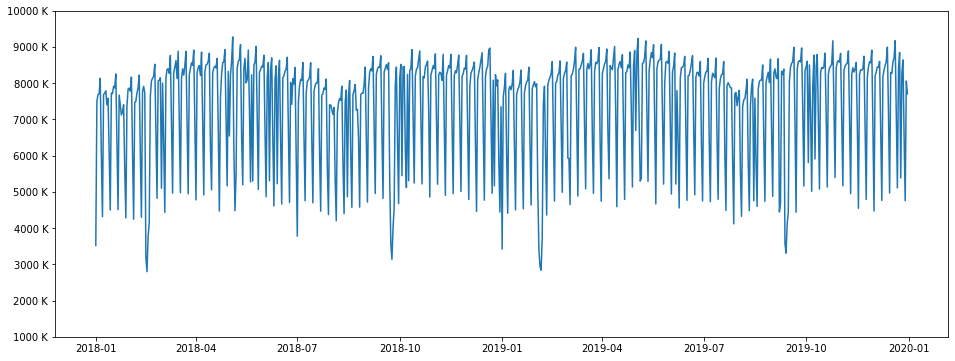

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(user_per_date.사용일자, user_per_date.일별이용자수/1000, label='expoential')

plt.ylim([1000, 10000])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
leg = plt.legend()
ax.get_legend().remove()

plt.show() 